<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>

This live training will review the concepts of statistical inference laid out in Statistical Thinking in Python I and II. The goal is to reinforce the concepts and techniques of statistical inference using hacker stats to help students gain confidence applying them to new data analysis tasks. Specifically, we will:

- Review fundamental notions of probability.
- Perform graphical exploratory data analysis (EDA).
- Review concepts of confidence intervals and null hypothesis significance tests (NHSTs).
- Apply bootstrap methods for computing confidence intervals.
- Investigate correlations in two-dimensional data.
- Perform a NHST comparing two treatments in a data set.

## **Necessary packages**

It is good practice to always have necessary package imports at the top of any `.py` file or notebook, so let's get our imports in before moving on. We will use the same set of packages we used in the Statistical Thinking in Python courses. We will use seaborn's defaults to make our plots stylish.

Unless I'll be plotting very large data sets (which is not the case in this webinar), I generally also like to set the figure format to be SVG. This avoids a pixelated look to the plots.

In [1]:
%load_ext blackcellmagic

import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# I want crisp graphics, so we'll output SVG
%config InlineBackend.figure_format = 'svg'

## **Statistical inference**

In this section of the notebook, I will discuss the goals of statistical inference and lay out the approach we will take. These ideas were present in the Statistical Thinking courses, but I am taking the opportunity here to be a bit more formal. In my experience, investigating a topic from multiple angles leads to a much fuller understanding, and that is my goal here.

We will dive into our (rather fun) data set momentarily, but for now, we will go over some important theoretical background to make sure we understand what statistical inference is all about, and how the hacker stats approach works.

### What is probability?

To think about what probability means, consider an example. Say I am interested in the heights of American adult women. If we were to select an American woman at random, I think we would all agree that she is probably going to be under 190 cm (about 6' 3"). We just used the word "probably!" To see what we mean by that, let's pick another woman at random. And another. And another. And another. We do this over and over and over. Eventually, we will pick a woman who is over 190 cm tall (for example basketball legend [Lisa Leslie](https://en.wikipedia.org/wiki/Lisa_Leslie) is 196 cm). So, the probability that a randomly chosen woman is over 190 cm is not zero, but is is small.

We can directly apply this mode of thinking to give us an interpretation of probability, referred to as the **frequentist interpretation of probability**. The probability of an observation represents a long-run frequency over a large number of identical repetitions of a measurement/data collection. These repetitions can be, and often are, hypothetical.

### Probability distributions and CDFs

A **probability distribution** provides the link between observations to probability. For example a Normal distribution might link women's heights to probability. It is highly probable that a woman is between 150 and 180 cm (about five and six feet) tall, but improbable that a woman is above 190 cm.

These statements of probability stem from the **cumulative distribution function** (CDF) associated with a probability distribution. The CDF evaluated at _x_ is defined as follows.

>CDF(_x_) = probability of observing a value less than or equal to _x_.

To get an idea of what a CDF might look like when we plot it, we can plot the CDF for a Normal distribution, say describing the height of American adult women. They average 165 cm, with a standard deviation of 9 cm. The mathematical expression for the CDF is complicated but known, and we can use the built-in functions in `scipy.stats` to generate the values.

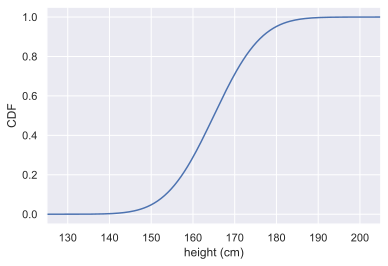

In [2]:
# x-values for height CDF
x = np.linspace(125, 205, 200)

# Values of the CDF
cdf = scipy.stats.norm.cdf(x, 165, 9)

# Make the plot
_ = plt.plot(x, cdf)
_ = plt.xlabel('height (cm)')
_ = plt.ylabel('CDF')
_ = plt.margins(x=0)

Remember, the CDF evaluated at a given position along the x-axis is the probability of having an observation less than or equal to _x_. So, if we look at _x_ = 160 cm, we see that the probability that a woman is shorter than 160 cm is about 0.3.

Importantly, the CDF contains all of the information about a distribution.

### Generative distributions

Say we did the experiment of measuring women's heights. For cost reasons (time and money), we can measure 100 women to get 100 height measurements. We might expect about 30 of these measurements to be below 160 cm and, based on the CDF above, about 7 of these measurements to be above 180 cm. This assumes that the distribution that provides that link between height measurements and probability is in fact a Normal distribution. If this is true, then the Normal distribution *generates* the data; it is the **generative distribution**.

If we *know* the true generative distribution, then drawing random numbers out of the distribution is the same as performing the measurements themselves. In the Statistical Thinking courses, we learned how to draw random numbers out of a probability distribution using the `numpy.random` module. So, we can "repeat" the measurement of 100 women by drawing out of the generative distribution.

In [3]:
# For reproducibility, seed the random number generator
np.random.seed(3252)

# Draw 100 measurments from a normal with mean 165 and std 9
heights = np.random.normal(165, 9, size=100)

### The empirical cumulative distribution function

As we discussed in DataCamp's Statistical Thinking courses, the **empirical cumulative distribution function**, or ECDF, is a useful plot to make when doing exploratory data analysis. The ECDF at position _x_ is defined as

>ECDF(_x_) = fraction of data points ≤ _x_.

Compare this to the definition of the CDF.

>CDF(_x_) = probability of observing a value less than or equal to _x_.

Think about the frequentist interpretation of probability. If we had many, many measurements, then the fraction of data points less than or equal to _x_ is in fact the *probability* of observing a value less than or equal to _x_. So, the ECDF is close to the CDF. The differences between an ECDF and the CDF of the generative distribution are due entirely to the fact that we have only a finite number of measurements for the ECDF.

In the Statistical Thinking courses, we learned how to plot ECDFs. We wrote a function to generate the x- and y-values for the ECDF.

In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n+1) / n

    return x, y

We can use this function to add the ECDF to our plot of the generative CDF.

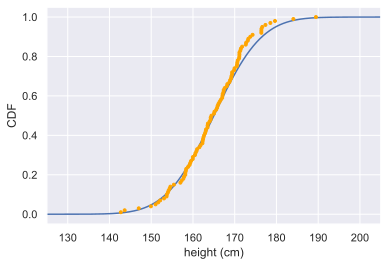

In [5]:
# Compute ECDF
x_ecdf, y_ecdf = ecdf(heights)

# Make the plot
_ = plt.plot(x, cdf)
_ = plt.plot(x_ecdf, y_ecdf, marker=".", linestyle="none", color="orange")
_ = plt.xlabel("height (cm)")
_ = plt.ylabel("CDF")
_ = plt.margins(x=0)

Indeed, the ECDF closely matches the CDF, but we do see variation from it, owing to the small sample size of 100. If we increase the sample size to 1000, the ECDF follows more closely.

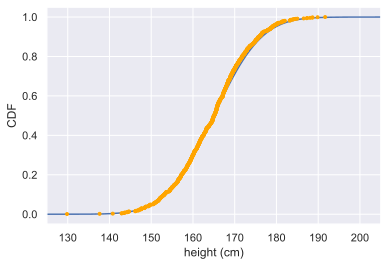

In [6]:
# Draw more heights
heights = np.random.normal(165, 9, size=1000)

# Compute ECDF
x_ecdf, y_ecdf = ecdf(heights)

# Make the plot
_ = plt.plot(x, cdf)
_ = plt.plot(x_ecdf, y_ecdf, marker=".", linestyle="none", color="orange")
_ = plt.xlabel("height (cm)")
_ = plt.ylabel("CDF")
_ = plt.margins(x=0)

### The task of statistical inference

In the above example, we knew the generative distribution. If we did actually know the generative distribution ahead of time, there would be no point in doing measurements. We generally do not know what the generative distribution is, so we collect data. **The task of statistical inference is to deduce the properties of a generative distribution of data.**

### The plug-in principle

We could imagine that we knew (or strongly suspected) that the generative distribution for American women's heights is Normal, but we do not know the parameters. In this case, the statistical inference task is largely to determine what the parameters of the generative distribution are.

But imagine we do not know anything a priori about the generative distribution. We still make measurements, and the measurements are all we have. We do not know anything about the CDF, but we do know about the ECDF. As the CDF defines a generative distribution, so too does the ECDF define an **empirical distribution**. We can proceed with statistical inference by using the empirical distribution in place of the (unknown) generative distribution. This approximation is referred to as the **plug-in** principle. This principle underlies many **non-parametric** approaches to statistical inference, so named because we are not trying to find parameters of a generative distribution, but are using only information from the data themselves. Application of the plug-in principle is the approach we take in this tutorial.

### Properties of distributions via plug-in estimates

One-dimensional distributions have properties you may have heard of, like means, medians, and variances. Imagine we have a set of measurements stored in a NumPy array `x`. Then, the plug-in estimates for the various properties of the generative distribution are shown in the table below.

| Property           | Plug-in estimate      |
|--------------------|-----------------------|
| mean               | `np.mean(x)`          |
| median             | `np.median(x)`        |
| variance           | `np.var(x)`           |
| standard deviation | `np.std(x)`           |
| _p_ percentile     | `np.percentile(x, p)` |



Two-dimensional distribution additionally have properties like covariances and correlations. We can also estimate these using the plug-in principle. Let `x` and `y` be NumPy arrays. Then, for two-dimensional distributions, the plug-in estimates are:

| Property           | Plug-in estimate              |
|--------------------|-------------------------------|
| covariance         | `np.cov(x, y, ddof=0)[0, 1]`  |
| correlation        | `np.corrcoef(x, y)[0, 1]`     |


### Onwards!

We have now laid the theoretical groundwork. In the data set we present below and subsequent analysis, we will use the plug-in principle to deduce properties about the generative distribution. For each set of measurements we consider, we will use the empirical distribution as a plug-in replacement for the unknown generative distribution and compute relevant properties.

## **The Dataset**

The data set in this webinar comes from a study by [Beattie, et al.](https://doi.org/10.1098/rsos.160321) in which they used the [Glasgow Facial Matching Test](https://en.wikipedia.org/wiki/Glasgow_Face_Matching_Test) (GFMT, [original paper](https://doi.org/10.3758/BRM.42.1.286)) to investigate how sleep deprivation affects a human subject's ability to match faces, as well as the confidence the subject has in those matches. Briefly, the test works by having subjects look at a pair of faces. Two such pairs are shown below.

<p align="center">
<img src="https://github.com/datacamp/Hacker-Stats-in-Python-Live-Training/blob/master/assets/gfmt_faces.png?raw=True" alt="GFMT faces" width="400px">
</p>
<br>


For each of 40 pairs of faces, the subject gets as much time as he or she needs and then says whether or not they are the same person. The subject then rates his or her confidence in the choice.

In this study, subjects also took surveys to determine properties about their sleep. The surveys provide three different metric of sleep quality and wakefulness. 

- The Sleep Condition Indicator (SCI) is a measure of insomnia disorder over the past month. High scores indicate better sleep and scores of 16 and below indicate insomnia. 
- The Pittsburgh Sleep Quality Index (PSQI) quantifies how well a subject sleeps in terms of interruptions, latency, etc. A higher score indicates poorer sleep. 
- The Epworth Sleepiness Scale (ESS) assesses daytime drowsiness.

We will explore how the various sleep metrics are related to each other and how sleep disorders affect subjects' ability to discern faces and their confidence in doing so.

### Loading and inspecting the data set

Let's load in the data set provided by Beattie and coworkers. We'll load in the data set and check out the first few rows using the `head()` method of pandas DataFrames. Importantly, missing data in this data set are denoted with an asterisk, which we specify using the `na_values` keyword argument.

In [7]:
# Read in the dataset
df = pd.read_csv(
    "https://github.com/datacamp/Hacker-Stats-in-Python-Live-Training/blob/master/data/gfmt_sleep.csv?raw=True",
    na_values="*",
)

# Print header
df.head()

,participant number,gender,age,correct hit percentage,correct reject percentage,percent correct,confidence when correct hit,confidence when incorrect hit,confidence when correct reject,confidence when incorrect reject,confidence when correct,confidence when incorrect,sci,psqi,ess
0,8,f,39,65,80,72.5,91.0,90.0,93.0,83.5,93.0,90.0,9,13,2
1,16,m,42,90,90,90.0,75.5,55.5,70.5,50.0,75.0,50.0,4,11,7
2,18,f,31,90,95,92.5,89.5,90.0,86.0,81.0,89.0,88.0,10,9,3
3,22,f,35,100,75,87.5,89.5,NaN,71.0,80.0,88.0,80.0,13,8,20
4,27,f,74,60,65,62.5,68.5,49.0,61.0,49.0,65.0,49.0,13,9,12


Here is some information about what is contained in each of the columns.

- `participant number`: Unique identifier for each subject
- `age`: Age of subject in years
- `correct hit percentage`: Percentage of correct responses among trials for which the faces match
- `correct reject percentage`: Percentage of correct responses among trials for which the faces do not match
- `percent correct`: Percentage of correct responses among all trials
- `confidence when correct hit`: Average confidence when the subject gave a correct response for trials for which the faces match
- `confidence when incorrect hit`: Average confidence when the subject gave an incorrect response for trials for which the faces match
- `confidence when correct reject`: Average confidence when the subject gave a correct response for trials for which the faces do not match
- `confidence when incorrect reject`: Average confidence when the subject gave an incorrect response for trials for which the faces do not match
- `confidence when correct`: Average confidence when the subject gave a correct response for for all trials
- `confidence when incorrect`: Average confidence when the subject gave a correct response for for all trials
- `sci`: The subject's Sleep Condition Indicator.
- `psqi`: The subject's Pittsburgh Sleep Quality Index.
- `ess`: The subject's Epworth Sleepiness Scale.

Going forward, it will be useful to separate the subjects into two groups, insomniacs and normal sleepers. We will therefore add an `'insomnia'` column to the DataFrame with True/False entries. Recall that a person is deemed an insomniac if their SCI is 16 or below.

In [8]:
# Add a column to the data frame for insomnia
df['insomnia'] = df['sci'] <= 16

It is important to know how many total subjects are included, so we can check on the length of the DataFrame.

In [9]:
len(df)

102

So, we have 102 subjects, hopefully enough to make meaningful comparisons.

With our data set in place, we can get moving with statistical inference.

## **Our approach**

Specifically, we will use statistical inference to address the following questions of the data.

1. How different is the facial matching performance of insomniacs versus normal sleepers?
2. How different is *confidence* in facial matching for insomniacs versus normal sleepers?
3. How are the different sleep metrics correlated?
4. How does drowsiness (ESS) correlate with facial matching performance?

Each question requires a different sort of analysis involving calculation of confidence intervals and p-values. Along the way, we will introduce the necessary theoretical and technical concepts.

Note that even though this webinar is about statistical inference, is is always important to do EDA first. Remember what [John Tukey](https://en.wikipedia.org/wiki/John_Tukey) said,

> "Exploratory data analysis can never be the whole story, but nothing else can serve as the foundation stone."

## **1. Performance of insomniacs versus normal sleepers**

Our first investigation is into how well insomniacs and perform the face matching task versus normal sleepers. As or first step in exploratory data analysis, we will make a plot of the ECDF of the percent correct on the facial matching test for the two categories.

As our first, step, we will compare the means of the two data sets. To do, we will extract the values of the `'percent correct'` column of the DataFrame for normal sleepers and for insomniacs. We will be sure to drop any missing data (NaNs). We will also convert these respective pandas Series to NumPy arrays, which enable faster computing.

In [10]:
# Extract percent correct for normal sleepers
pcorr_normal = df.loc[~df['insomnia'], 'percent correct'].dropna().values

# Extract percent correct for insomniacs
pcorr_insom = df.loc[df['insomnia'], 'percent correct'].dropna().values

We can now compute the ECDFs and plot them.

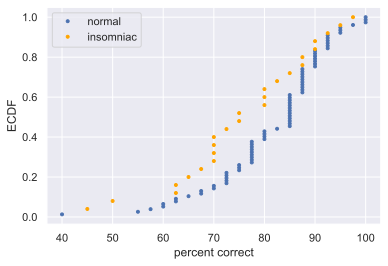

In [11]:
# Compute ECDF for normal sleepers
x_normal, y_normal = ecdf(pcorr_normal)

# Compute ECDF for insomniacs
x_insom, y_insom = ecdf(pcorr_insom)

# Make plot of ECDFs
_ = plt.plot(x_normal, y_normal, marker=".", linestyle="none", label="normal")
_ = plt.plot(
    x_insom,
    y_insom,
    marker=".",
    linestyle="none",
    color="orange",
    label="insomniac",
)
_ = plt.xlabel("percent correct")
_ = plt.ylabel("ECDF")
_ = plt.legend()

There are clearly fewer data points for insomniacs (25 versus 77 for normal sleepers), which will be important to consider as we do statistical inference. In eyeballing the ECDFs, it appears that those without insomnia perform a bit better; the ECDF is shifted rightward toward better scores.

### Plug-in estimates

We have already computed a plug-in estimate! The ECDF itself is a plug-in estimate for the CDF. From the ECDF, we can also directly read off plug-in estimates for any percentile. For example, the median is the 50th percentile; it is the percent correct where the ECDF is 0.5. That is, half of the measurements lie below and half above. The median for normal sleepers is 85 and that for insomniacs is 75, a 10% difference.

We can also get plug-in estimates for the mean. These we can't read directly off of the ECDF, but can compute them using the `np.mean()` function.

In [12]:
# Plug in estimates for means
pcorr_normal_mean = np.mean(pcorr_normal)
pcorr_insom_mean = np.mean(pcorr_insom)

# Print the results
print("Plug-in estimates for the mean pecent correct:")
print("normal sleepers:", pcorr_normal_mean)
print("insomniacs:     ", pcorr_insom_mean)

Plug-in estimates for the mean pecent correct:
normal sleepers: 81.46103896103897
insomniacs:      76.1


There is about a 5% difference in the mean scores. In looking at the ECDFs, it seems like this (or the median) might be a good difference to use to compare insomniacs and normal sleepers because the ECDFs are similar at the tails (low and high percent correct), but differ in the middle.

### **Computing a confidence interval**

So, we are now faced with the question: If I were to do the same experiment again, how much variation would I get in the mean percent correct? Might we again see that the insomniacs perform more poorly?

To answer this questions, we can compute a **confidence interval**. A **confidence interval** can be defined as follows.

>If an experiment is repeated over and over again, the estimate I compute will lie between the bounds of the 95% confidence interval for 95% of the experiments.

So, all we have to do it go to Scotland, randomly select 102 people, 27 of whom are insomniacs, and perform the face matching test, record the results, and compute the mean for insomniacs and normal sleepers. Then, we have to go back to Scotland, do the whole procedure again, and do that again, and again, and again. Simple, right? 

Of course, we can't do that! But remember that performing an experiment is the same thing as drawing random samples out of the generative distribution. Because the generative distribution is unknown, the only way we know how to sample out of it is to literally do the experiment again, which is just not possible. However, we can use the plug-in principle to *approximate* the generative distribution with the empirical distribution. We *can* sample out of the empirical distribution using NumPy's random number generation! A sample of a new data set drawn from the empirical distribution is called a **bootstrap sample**. 

Imagine we have set of measurements stored in NumPy array `data`. To get a bootstrap sample, we use `np.random.choice()` to draw `len(data)` numbers out of the array `data`. We do this *with replacement*. The result is a bootstrap sample. The syntax is

    bs_sample = np.random.choice(data, len(data))
    
The bootstrap sample is approximately a new data set drawn from the generative distribution.

After drawing a bootstrap sample, we want to compute the mean in order to see how it will change from experiment to experiment. A mean (or other value of interest) computed from a bootstrap sample is referred to as a **bootstrap replicate**. We can write a function, as we did in Statistical Thinking II, to compute a bootstrap replicate. This function takes as arguments a 1D array of data `data` and a function `func` that is to be applied to the bootstrap samples to return a bootstrap replicate.

In [13]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    
    return func(bs_sample)

Now, we want to compute many of these replicates so we can see what range of values for the mean comprises the middle 95%, which is give a 95% confidence interval. It is therefore useful to write a function to draw many bootstrap replicates (again as we did in Statistical Thinking II).

In [14]:
def draw_bs_reps(data, func, size=1):
    """Draw `size` bootstrap replicates."""
    # Initialize array of replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

Excellent! Let's put these functions to use to draw bootstrap replicates of the mean for normal sleepers and for insomniacs. Because this calculation is fast, we can "do" the experiment over and over again many times. We'll do it 10,000 times.

In [15]:
# Draw bootstrap replicates for the mean
bs_reps_normal = draw_bs_reps(pcorr_normal, np.mean, size=10000)
bs_reps_insom = draw_bs_reps(pcorr_insom, np.mean, size=10000)

# Take a quick peak
bs_reps_normal

array([78.73376623, 81.46103896, 79.83766234, ..., 83.44155844,
       79.51298701, 79.48051948])

The replicates are stored in NumPy arrays of length 10,000. The values hover around the means, but they do vary.

We can compute the percentiles of the bootstrap replicates using the `np.percentile()` function. We pass in the array we want to compute percentiles for, followed by a list of the percentiles we want. For a 95% confidence interval, we can use `[2.5, 97.5]`, which will give the middle 95% of the samples.

In [16]:
# Compute 95% confidence intervals of the mean
conf_int_normal = np.percentile(bs_reps_normal, [2.5, 97.5])
conf_int_insom = np.percentile(bs_reps_insom, [2.5, 97.5])

# Print confidence intervals
print("Normal sleepers:", conf_int_normal)
print("Insomniacs:     ", conf_int_insom)

Normal sleepers: [78.86363636 83.8961039 ]
Insomniacs:      [70.9 81. ]


The 95% confidence interval of the mean for normal sleepers ranges over 5%, from 79 to 84%. That for insomniacs is twice as wide, ranging from 71 to 81%. 

### **Automating and organizing confidence intervals**

There are many useful quantities we obtained by going through the above procedure. We took an array of data, computed the x- and y-values for an ECDF, defined a function to compute a plug-in estimate (in our case, the mean), used the function to compute the estimate, generated bootstrap replicates of the estimate, and computed a confidence interval. We did this for two categories, normal sleepers and insomniacs.

At various points in our analyses, we might like to access these results. It is therefore useful to define a class to compute and store the results of a 1D confidence interval calculation.

In [24]:
class ConfInt1D(object):
    """Class for computing and storing confidence intervals from
    one-dimensional data."""
    def __init__(
        self, data, func, ptiles=(2.5, 97.5), n_bs_reps=10000, category=None
    ):
        # Store data and settings
        self.data = data
        self.func = func
        self.ptiles = ptiles
        self.n_bs_reps = n_bs_reps
        self.category = category
        
        # Compute ECDF x and y values
        self.ecdf_x, self.ecdf_y = ecdf(self.data)

        # Compute plug-in estimate
        self.estimate = func(data)
        
        # Compute bootstrap confidence interval
        self.bs_reps = draw_bs_reps(data, func, size=n_bs_reps)
        self.conf_int = np.percentile(self.bs_reps, ptiles)

### **Visualizing confidence intervals**

The confidence intervals we printed above are useful, but the confidence intervals are perhaps better visualized graphically. The function below generates a plot of confidence intervals. It takes are arguments a list of `ConfInt1D` instances.

In [18]:
def plot_conf_ints(confints):
    """Plot confidence intervals with estimates."""
    # A lovely blue color
    color = "#1f77b3"
    
    cats = [ci.category for ci in confints][::-1]
    estimates = [ci.estimate for ci in confints][::-1]
    conf_intervals = [ci.conf_int for ci in confints][::-1]

    # Set up axes for plot
    fig, ax = plt.subplots(figsize=(5, len(cats)/2))

    # Plot estimates as dots
    ax.plot(
        estimates,
        cats,
        marker=".",
        linestyle="none",
        markersize=10,
        color=color,
    )

    # Plot confidence intervals as lines
    for cat, conf_int in zip(cats, conf_intervals):
        ax.plot(conf_int, [cat] * 2, linewidth=3, color=color)

    # Make sure margins look ok
    ax.margins(y=0.25 if len(cats) < 3 else 0.125)

    return ax

Let's make a plot. We set up `ConfInt1D` instances for normal sleepers and insomniacs and pass them to the function.

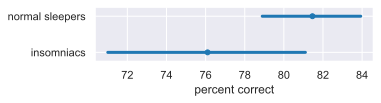

In [20]:
# Instantiate classes
pcorr_normal = ConfInt1D(pcorr_normal, np.mean, category="normal sleepers")
pcorr_insom = ConfInt1D(pcorr_insom, np.mean, category="insomniacs")

# Make plot
ax = plot_conf_ints([pcorr_normal, pcorr_insom])
_ = ax.set_xlabel("percent correct")

The difference in the length of the confidence interval is starkly apparent on the plot. Because we had fewer measurements for insomniacs, we can't be too precise in what mean values we might get.

In looking at the plot of confidence intervals, it seems possible that if we did the experiment again, we might even get a scenario where insomniacs perform *better* than normal sleepers. But how likely is such a scenario?

### **Confidence interval for difference of means**

Remember that we are not restricted as to what confidence intervals we can compute. We can instead compute a confidence interval on the *difference* of means between normal sleepers and insomniacs. To do this, we do the following procedure, which again uses the plug-in principle to "do" the experiment again to get a bootstrap replicate of the difference of means.

1. Generate a bootstrap sample of percent correct for normal sleepers.
2. Generate a bootstrap sample of percent correct for insomniacs.
3. Take the mean of each bootstrap sample, giving a bootstrap replicate for the mean of each.
4. Subtract the mean for insomniacs from that of normal sleepers.

This is actually trivial to do now because we have already computed and stored bootstrap replicates of the means! We simply have to subtract them.

In [21]:
# Get bootstrap replicates for difference of means
bs_reps_diff_of_means = pcorr_normal.bs_reps - pcorr_insom.bs_reps

Now, we can compute the confidence interval by finding the percentiles.

In [22]:
np.percentile(bs_reps_diff_of_means, [2.5, 97.5])

array([-0.19487013, 11.1199026 ])

The confidence interval just barely crosses zero, suggesting that the insomniacs will rarely perform better than normal sleepers. 

We can find out the *probability* of having the insomniacs perform better than the normal sleepers by counting how many times the mean percent correct for insomniacs exceeded that of normal sleepers and dividing by the total number of bootstrap replicates. To do the count, we can make an array containing `True` and `False` values for whether or not the difference of means is negative and sum the result (since `True` is worth 1 and `False` is worth 0).

In [23]:
# Compute probability of having insomniacs have better mean score
np.sum(bs_reps_diff_of_means <= 0) / len(bs_reps_diff_of_means)

0.0301

So, if we were to do the experiment again, there is about a 3% chance we would observe the insomniacs performing at parity of better than the normal sleepers, at least based on the observations we have. If we did more actual observations, this chance could rise or fall; we cannot know without more measurements.

### **Summarizing the results in a report**

There are many opinions about displaying the results of an analysis like this one.

## **2. Confidence of insomniacs versus normal sleepers**

There seems to be a difference in performance between normal sleepers and insomniacs. Now, let's compare how well the subjects *think* they are doing in their responses. We will investigate their confidence when correct and incorrect in the face matching tasks for both insomniacs and normal sleepers. We start by extracting the measurements from the DataFrame as NumPy arrays.

In [41]:
# Extract confidences for normal sleepers
conf_corr_normal = (
    df.loc[~df["insomnia"], "confidence when correct"].dropna().values
)
conf_incorr_normal = (
    df.loc[~df["insomnia"], "confidence when incorrect"].dropna().values
)

# Extract confidences for insomniacs
conf_corr_insom = (
    df.loc[df["insomnia"], "confidence when correct"].dropna().values
)
conf_incorr_insom = (
    df.loc[df["insomnia"], "confidence when incorrect"].dropna().values
)

### **Performing the analysis (the automated way)**

The analysis pipeline is much the same as we did for looking at the percent correct. We will again compute means and confidence intervals of the mean. We can conveniently use our ConfInt1D class to do all of the calculations.

In [42]:
# Put into classes
conf_corr_normal = ConfInt1D(
    conf_corr_normal, np.mean, category="normal when correct",
)
conf_incorr_normal = ConfInt1D(
    conf_incorr_normal, np.mean, category="normal when incorrect",
)
conf_corr_insom = ConfInt1D(
    conf_corr_insom, np.mean, category="insomniac when correct"
)
conf_incorr_insom = ConfInt1D(
    conf_incorr_insom, np.mean, category="insomniac when incorrect"
)

### **EDA**

While we did just compute confidence intervals, we should always do a bit of EDA to check things out. We will plot the ECDFs of all four classes (confidence when correct and incorrect for normal sleepers and insomniacs) and overlay them on the same plot.

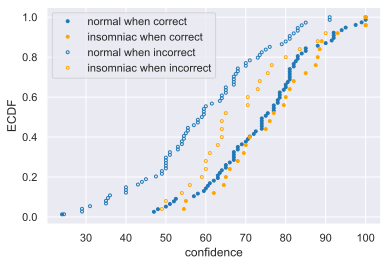

In [43]:
# Dictionary of kwargs for convenience
kwargs = {'marker': '.', 'linestyle': 'none'}

# Plot ECDFs
_ = plt.plot(
    conf_corr_normal.ecdf_x,
    conf_corr_normal.ecdf_y,
    color="#1f77b3",
    label=conf_corr_normal.category,
    **kwargs,
)
_ = plt.plot(
    conf_corr_insom.ecdf_x,
    conf_corr_insom.ecdf_y,
    color="orange",
    label=conf_corr_insom.category,
    **kwargs,
)
_ = plt.plot(
    conf_incorr_normal.ecdf_x,
    conf_incorr_normal.ecdf_y,
    color="#1f77b3",
    fillstyle="none",
    label=conf_incorr_normal.category,
    **kwargs,
)
_ = plt.plot(
    conf_incorr_insom.ecdf_x,
    conf_incorr_insom.ecdf_y,
    color="orange",
    fillstyle="none",
    label=conf_incorr_insom.category,
    **kwargs,
)

# Adjust labels
_ = plt.xlabel("confidence")
_ = plt.ylabel("ECDF")
_ = plt.legend()

We see a few striking trends directly from the ECDF.

1. Regardless of sleep quality, subjects are less confident in their responses when they are wrong.
2. When they are right, insomniacs and normal sleepers seem to have the same level of confidence in their responses.
3. When they are wrote, insomniacs have more confidence in their responses than normal sleepers.

This last point is really interesting. The insomniacs seem less likely to *know when they are wrong.* This kind of cognitive impairment could have real repercussions in how they go about their lives. We will give this last difference special attention.

### **Plug-in estimates and confidence intervals**

We have already computed the plug-in estimates for the mean and confidence intervals when we instantiated the classes. Let's compare them.

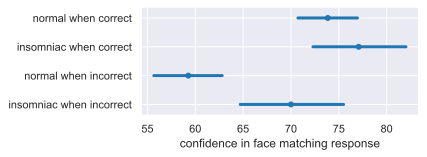

In [48]:
# Make plot of confidence intervals
ax = plot_conf_ints(
    [conf_corr_normal, conf_corr_insom, conf_incorr_normal, conf_incorr_insom]
)
_ = ax.set_xlabel("confidence in face matching response")

The evidence from this plot is clear. Insomniacs are more confident that they have provided a correct answer when they have not. The difference is about 10% on the confidence scale, which is about 20% of the entire range of responses from subjects about their confidence. If we were to perform the experiment again, we would very likely continue to see this discrepancy.

### Defining null hypothesis significance tests

We have already drawn telling conclusions from the data from the analysis above. Considering the confidence when incorrect, the rightward shift of the ECDF for insomniacs relative to normal sleepers strongly suggests the overconfidence of insomniacs. The confidence intervals make clear that this effect is not do to the inherent variability among participants and the small sample size. We really could conclude our analysis there.

Nonetheless, we will proceed to do a null hypothesis significance test. In some fields, this is referred to as an A/B test. I do so primarily because they are widely used and are important to know how to do and to interpret. I will give further commentary about why the results of NHST should not carry as much weight as conclusions derived from graphical EDA with ECDFs and calculation of confidence intervals.

I begin by reviewing what a NHST is. A typical hypothesis test consists of these steps.

1. Clearly state the hypothesis being considered, referred to as the **null hypothesis**.
2. Define a **test statistic**, a scalar value that you can compute from data, almost always a statistical functional of the empirical distribution. Compute it directly from your measured data.
3. *Simulate* data acquisition for the scenario where the null hypothesis is true. Do this many times, computing and storing the value of the test statistic each time.
4. The fraction of simulations for which the test statistic is at least as extreme as the test statistic computed from the measured data is called the **p-value**, which is what you report.

We need to be clear on our definition here. The p-value is the probability of observing a test statistic being at least as extreme as what was measured if the null hypothesis is true. It is exactly that, and nothing else. It is not the probability that the null hypothesis is true. In the frequentist interpretation of probability, we cannot assign a probability to the truth of a hypothesis.

A complete definition of a hypothesis test then has the following components.

- The null hypothesis
- The test statistic
- What it means to be at least as extreme. 

All of the named hypothesis tests you may have heard of, like the Student-t test, the Mann-Whitney U-test, Welch’s t-test, etc., describe a specific hypothesis with a specific test statistic with a specific definition of what it means to be at least as extreme (e.g., one-tailed or two-tailed). I can never remember what these are, nor do I encourage you to; you can always look them up. Rather, you should just clearly write out what your test is in terms of the hypothesis, test statistic, and definition of extremeness.

### **Performing a NHST**

To perform a hypothesis test using hacker stats, we will follow the prescription laid out above. We of course have to start by specifying our test.

- Null hypothesis: The generative distributions for reported confidence is the same for insomniacs as it is for normal sleepers.
- Test statistic: Mean confidence of normal sleepers minus that of insomniacs.
- At least as extreme as: The test statistic is less than or equal to the observed difference of means.

The bread and butter of conducting a hypothesis is simulating data acquisition under the null hypothesis. For this specific hypothesis, that the distributions are the same, there is a very straight-forward way of simulating it. Let `x` and `y` be our two arrays, with `m` entries in `x` and `n` entries in `y`.

1. Concatenate the two data sets into one. This is done with `np.concatenate((x, y))`.
2. Randomly scramble the order of the combined data set. This is accomplished using `np.random.permutation()`.
3. Designate the first `m` entries in this scrambled array to be "x" and the remaining to be "y."

We then use these new "x" and "y" arrays to compute the test statistic.

This simulation is exact; it is as if the label of the data set has no meaning; hence the distributions of the two data sets are entirely equal. Note that we are *not* say what the distribution is, only that the two data sets have the *same* distribution. 

A test done in this way is referred to as a **permutation test**. A **permutation sample** is akin to a bootstrap sample; it is a new pair of data sets generated after scrambling the concatenated data set. A **permutation replicate** is a value of the test statistic computed from a permutation sample, in this case the difference of means.

Let's code up the functions to do the test, starting with generating the permutation sample.

In [49]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

We need to provide a function that takes in two data sets (a permutation sample or the original data sets) and computes the test statistic. In our case, this is the difference of means.

In [50]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    return np.mean(data_1) - np.mean(data_2)

Finally, we can write a function to generate multiple permutation replicates.

In [51]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

We'll start with the confidence when giving correct answers to the face matching test for insomniacs versus normal sleepers. We start by computing the test statistic from the actual measurements.

In [53]:
# Compute difference of means from original data
test_stat = diff_of_means(conf_corr_normal.data, conf_corr_insom.data)

# Take a look
test_stat

-3.22935064935065

Now, we'll draw permutation replicates.

In [56]:
# Acquire permutation replicates
perm_reps = draw_perm_reps(
    conf_corr_normal.data, conf_corr_insom.data, diff_of_means, size=10000
)

Now, we'll see what fraction were less than or equal to the test statistic calculated from the measured data sets.

In [57]:
# Compute p-value
p_value = np.sum(perm_reps <= test_stat) / len(perm_reps)

# Take a look
p_value

0.1572

In this case, the p-value is about 0.16, which means that about 16% of the time, the null hypothesis that the confidence when correct for insomniacs and normal sleepers is the same will generate a difference of means at least as different in magnitude than what was observed. The data are then commensurate with the null hypothesis; they do not serve to rule out that hypothesis.

Now, let's do the same analysis for the case where the subjects responded incorrectly to the face matching test.

In [67]:
# Compute difference of means from original data
test_stat = diff_of_means(conf_incorr_normal.data, conf_incorr_insom.data)

# Acquire permutation replicates
perm_reps = draw_perm_reps(
    conf_incorr_normal.data, conf_incorr_insom.data, diff_of_means, size=10000
)

# Compute p-value
p_value = np.sum(perm_reps <= test_stat) / len(perm_reps)

# Take a look
p_value

0.0016

This p-value is much smaller. Only 0.1 or 0.2% of the permutation samples had a difference of means less than or equal to what was observed. According to this result, it is unlikely that the observed data set could have been generated by identical distributions for normal sleepers and insomniacs. We did already know this from our analysis of the confidence intervals, and this is the icing on the cake.

## **3. Correlation of sleep metrics**

## **4. Effect of drowsiness on performance**

## **Further study**

- Does performance in the tests correlate with age? How about confidence?
- Do we see gender differences in performance? How about confidence?

Finally, I'll note that we also import [dc_stat_think](https://github.com/justinbois/dc_stat_think) as `dcst`. This is a package that contains all of the functions that learners wrote in the Statistical Thinking courses (including Case Studies in Statistical Thinking). We will use it directly until the very end, since it will be good practice here to go over how those functions are constructed.